In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from config import *
%matplotlib inline

In [2]:
data = pd.read_csv(os.path.expanduser(PROCESSED_DATA_FOLDER+PROCESSED_FILE),
                   parse_dates=['check_date', 'departure_time'])

In [3]:
#data = data.sort_values('check_date')

In [4]:
data.head()

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.99,1.437401e+12
1,117,2015-07-20 14:00:01.250,STN,POZ,2015-10-16,2015-10-16 11:20:00,2015-10-16 14:25,FR2336,33.99,33.99,1.437401e+12
2,118,2015-07-20 14:00:01.250,STN,POZ,2015-10-17,2015-10-17 11:20:00,2015-10-17 14:25,FR2336,18.99,18.99,1.437401e+12
3,119,2015-07-20 14:00:01.250,STN,POZ,2015-10-18,2015-10-18 11:20:00,2015-10-18 14:25,FR2336,22.99,22.99,1.437401e+12
4,120,2015-07-20 14:00:01.250,STN,POZ,2015-10-19,2015-10-19 11:20:00,2015-10-19 14:25,FR2336,18.99,18.99,1.437401e+12


In [5]:
data['check_date'].describe()

count                           9003
unique                            57
top       2015-08-30 09:00:01.618000
freq                             180
first     2015-07-20 14:00:01.250000
last      2015-10-08 21:00:01.563000
Name: check_date, dtype: object

In [6]:
# TO DATETIME
data['departure_time'] = pd.to_datetime(data['departure_time'])

In [7]:
# EXPAND 
data['days_to_flight'] = data.apply(lambda x: (x['departure_time'] - x['check_date']).days, axis=1)

In [8]:
# NORMALISE PRICE (subtract init, divide by init)
price_init = data.sort_values('check_date').groupby('departure_time').first()['price_gbp'].to_dict()

data['price_init'] = data.apply(lambda x: price_init[x['departure_time']], axis=1)
data['price_offset'] = data['price_gbp'] - data['price_init']
data['price_norm'] = data['price_offset']/data['price_init']

In [9]:
flights = list(data['flight_number'].unique())
colors = dict(zip(flights, sns.color_palette('muted', len(flights))))
data['flight_color'] = data['flight_number'].apply(lambda f: colors[f])

In [10]:
# departures = list(data['departure_time'].unique())
departures = [pd.Timestamp(date) for date in data['departure_time'].unique()]
colors = dict(zip(departures, sns.color_palette('muted', len(departures))))
data['departure_color'] = data['departure_time'].apply(lambda f: colors[f])


In [11]:
a = departures[0]
pd.Timestamp(a)

Timestamp('2015-10-20 16:35:00')

In [12]:
def plot_days_to_flight_scatter(df, price='price_gbp', color_map='flight_color'):
    df.plot.scatter('days_to_flight', price,
                    #logx=True, logy=True,
                    s=50,
                    c=df[color_map])

In [13]:
data['flight_number'].unique()

array(['FR7921', 'FR2336', 'FR6653', 'FR6652', 'FR2337', 'FR7922',
       'FR6618', 'FR6619', 'FR6266', 'FR6267'], dtype=object)

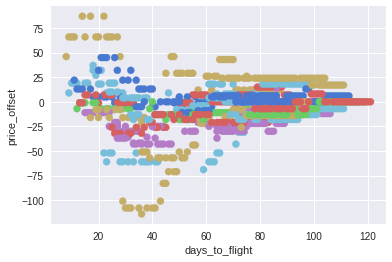

In [14]:
plot_days_to_flight_scatter(data[data['flight_number']=='FR6266'], price='price_offset', color_map='departure_color')

In [15]:
data[data['flight_number'] == 'FR6266'][]

SyntaxError: invalid syntax (<ipython-input-15-19ca5319ba66>, line 1)

In [16]:
data[data['price_init'] == 147.99]

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,price_init,price_offset,price_norm,flight_color,departure_color
163,49,2015-07-20 14:00:01.250,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,147.99,147.99,1.437401e+12,109,147.99,0.0,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
291,20,2015-07-21 09:00:01.385,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,147.99,147.99,1.437469e+12,108,147.99,0.0,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
534,61,2015-07-22 09:00:02.012,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,147.99,147.99,1.437556e+12,107,147.99,0.0,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
566,90,2015-07-23 11:00:01.884,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,147.99,147.99,1.437649e+12,106,147.99,0.0,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
765,90,2015-07-24 11:00:01.581,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,147.99,147.99,1.437736e+12,105,147.99,0.0,0.000000,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
917,42,2015-07-25 11:00:01.695,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,171.99,171.99,1.437822e+12,104,147.99,24.0,0.162173,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
1204,13,2015-07-26 10:00:02.058,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,171.99,171.99,1.437905e+12,103,147.99,24.0,0.162173,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
1435,116,2015-07-27 09:00:01.543,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,171.99,171.99,1.437988e+12,102,147.99,24.0,0.162173,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
1526,157,2015-07-28 09:00:02.288,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,171.99,171.99,1.438074e+12,101,147.99,24.0,0.162173,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"
1673,20,2015-07-29 09:00:02.209,EDI,BCN,2015-11-07,2015-11-07 06:25:00,2015-11-07 10:10,FR6266,171.99,171.99,1.438160e+12,100,147.99,24.0,0.162173,"(0.8392156862745098, 0.37254901960784315, 0.37...","(0.7686274509803922, 0.6784313725490196, 0.4)"


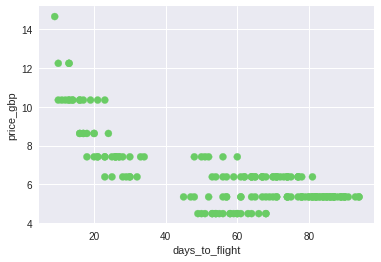

In [17]:
plot_days_to_flight_scatter(data[data['flight_number'] == 'FR6619'])

In [18]:
data.sort_values('check_date')

,Unnamed: 0,check_date,from,to,flight_date,departure_time,arrival_time,flight_number,price,price_gbp,timestamp_ms,days_to_flight,price_init,price_offset,price_norm,flight_color,departure_color
0,1,2015-07-20 14:00:01.250,EDI,GDN,2015-10-20,2015-10-20 16:35:00,2015-10-20 19:55,FR7921,23.99,23.990000,1.437401e+12,92,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.2823529411764706, 0.47058823529411764, 0.81..."
115,91,2015-07-20 14:00:01.250,EDI,AGP,2015-11-16,2015-11-16 06:25:00,2015-11-16 10:45,FR6652,46.99,46.990000,1.437401e+12,118,46.990000,0.0000,0.000000,"(0.7058823529411765, 0.48627450980392156, 0.78...","(0.8392156862745098, 0.37254901960784315, 0.37..."
116,4,2015-07-20 14:00:01.250,EDI,GDN,2015-10-29,2015-10-29 16:45:00,2015-10-29 20:05,FR7921,23.99,23.990000,1.437401e+12,101,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.7058823529411765, 0.48627450980392156, 0.78..."
117,5,2015-07-20 14:00:01.250,EDI,GDN,2015-10-31,2015-10-31 16:45:00,2015-10-31 20:05,FR7921,23.99,23.990000,1.437401e+12,103,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.7686274509803922, 0.6784313725490196, 0.4)"
118,6,2015-07-20 14:00:01.250,EDI,GDN,2015-11-03,2015-11-03 16:45:00,2015-11-03 20:05,FR7921,23.99,23.990000,1.437401e+12,106,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.4666666666666667, 0.7450980392156863, 0.858..."
119,7,2015-07-20 14:00:01.250,EDI,GDN,2015-11-05,2015-11-05 16:45:00,2015-11-05 20:05,FR7921,23.99,23.990000,1.437401e+12,108,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.2823529411764706, 0.47058823529411764, 0.81..."
120,8,2015-07-20 14:00:01.250,EDI,GDN,2015-11-07,2015-11-07 16:45:00,2015-11-07 20:05,FR7921,23.99,23.990000,1.437401e+12,110,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.41568627450980394, 0.8, 0.396078431372549)"
121,9,2015-07-20 14:00:01.250,EDI,GDN,2015-11-10,2015-11-10 16:45:00,2015-11-10 20:05,FR7921,23.99,23.990000,1.437401e+12,113,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.8392156862745098, 0.37254901960784315, 0.37..."
122,10,2015-07-20 14:00:01.250,EDI,GDN,2015-11-12,2015-11-12 16:45:00,2015-11-12 20:05,FR7921,23.99,23.990000,1.437401e+12,115,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.7058823529411765, 0.48627450980392156, 0.78..."
114,3,2015-07-20 14:00:01.250,EDI,GDN,2015-10-27,2015-10-27 16:45:00,2015-10-27 20:05,FR7921,23.99,23.990000,1.437401e+12,99,23.990000,0.0000,0.000000,"(0.2823529411764706, 0.47058823529411764, 0.81...","(0.41568627450980394, 0.8, 0.396078431372549)"
